<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/final_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/

Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)



2.9.2


seed for reproducivity

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Exploration Data Analysis (EDA)

unzip data file

In [ ]:
# Load the dataset to be used for classification
if not os.path.exists('x_train.npy'):
  !unzip training_dataset_homework2.zip

load the data

In [ ]:
x = np.load('x_train.npy', encoding='bytes')
y = np.load('y_train.npy', encoding='bytes')

In [ ]:
x.shape

(2429, 36, 6)

In [ ]:
y.shape

(2429,)

Count the number of occurrences for each label in the dataset

In [ ]:
classes_list = ['Wish',         # 0
                'Another',      # 1
                'Comfortably',  # 2
                'Money',        # 3
                'Breathe',      # 4
                'Time',         # 5
                'Brain',        # 6
                'Echoes',       # 7
                'Wearing',      # 8
                'Sorrow',       # 9
                'Hey',          # 10
                'Shine']        # 11

count = [0,0,0,0,0,0,0,0,0,0,0,0]

In [ ]:
from collections import Counter

counter = Counter(y)
tot_number = 0;

for i in range(len(classes_list)):
  count[i] = counter[i]
  tot_number += count[i]
  print("The number of ", classes_list[i], " is: ", count[i])

print("The total number of data is: ", tot_number)

The number of  Wish  is:  34
The number of  Another  is:  123
The number of  Comfortably  is:  270
The number of  Money  is:  381
The number of  Breathe  is:  62
The number of  Time  is:  153
The number of  Brain  is:  313
The number of  Echoes  is:  68
The number of  Wearing  is:  120
The number of  Sorrow  is:  777
The number of  Hey  is:  77
The number of  Shine  is:  51
The total number of data is:  2429


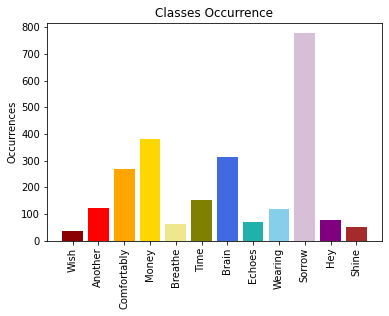

In [ ]:
erc = ['darkred','red', 'orange', 'gold', 'khaki', 'olive', 'royalblue', 'lightseagreen', 'skyblue','thistle', 'purple', 'brown']
plt.bar(classes_list, count, color = erc)
plt.title("Classes Occurrence")
plt.ylabel("Occurrences")
plt.xticks(rotation=90)
plt.yticks
plt.show()

Visualization of the data

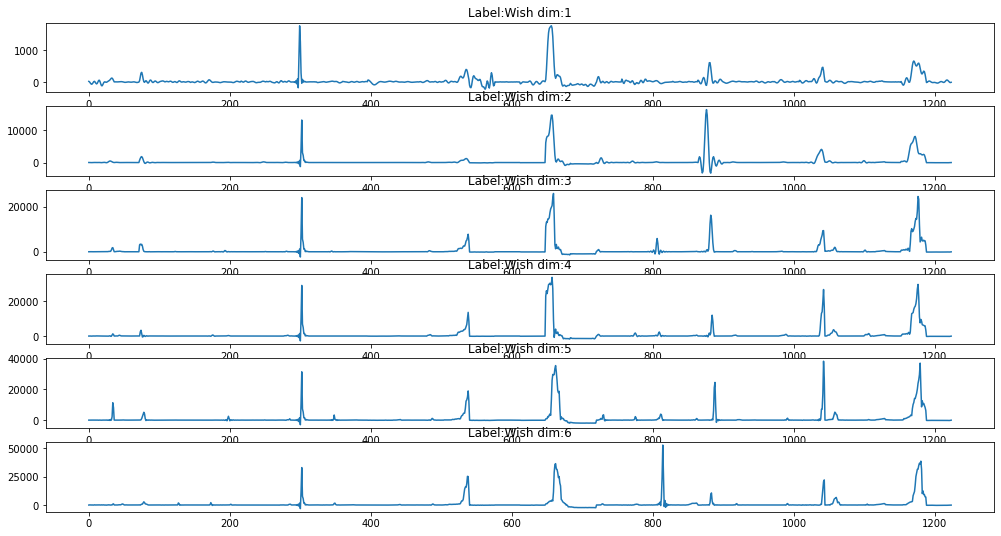

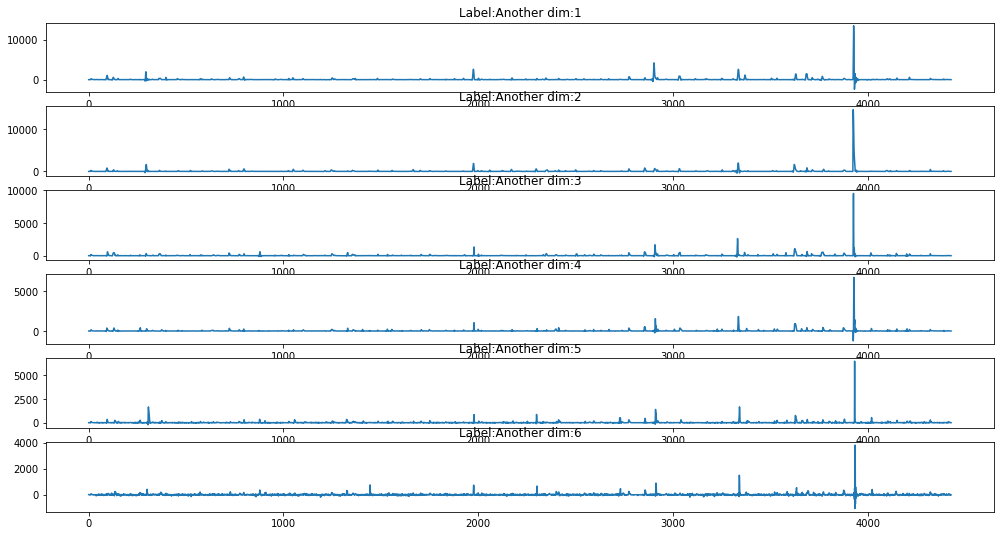

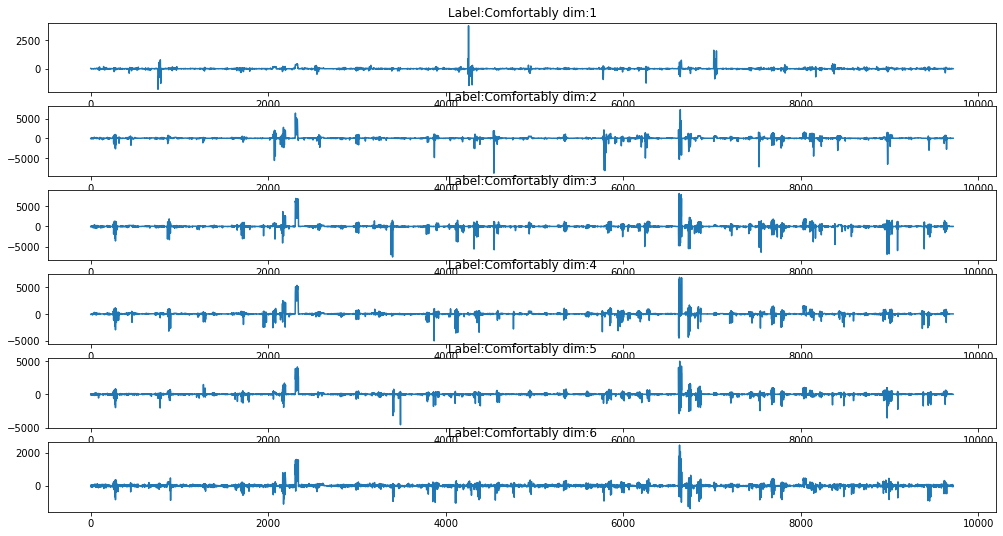

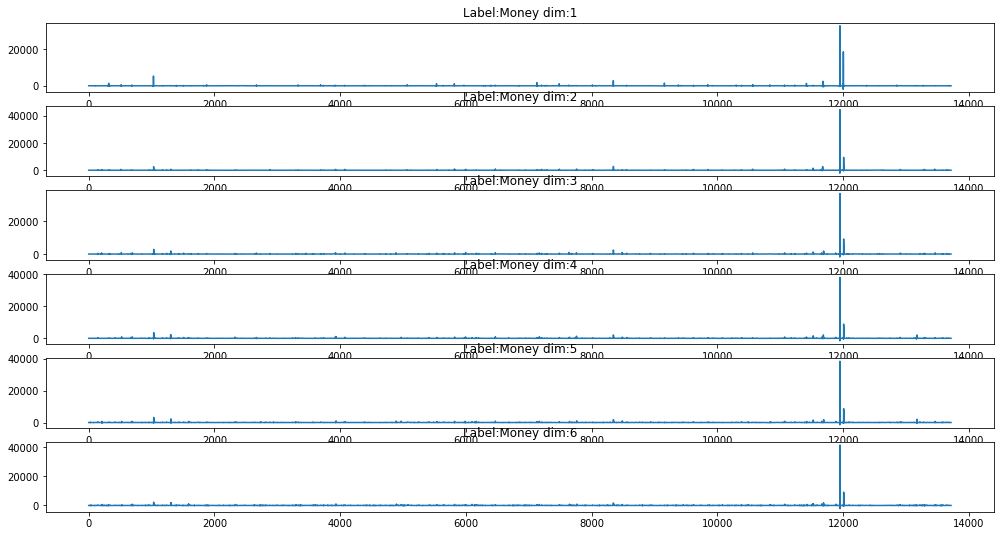

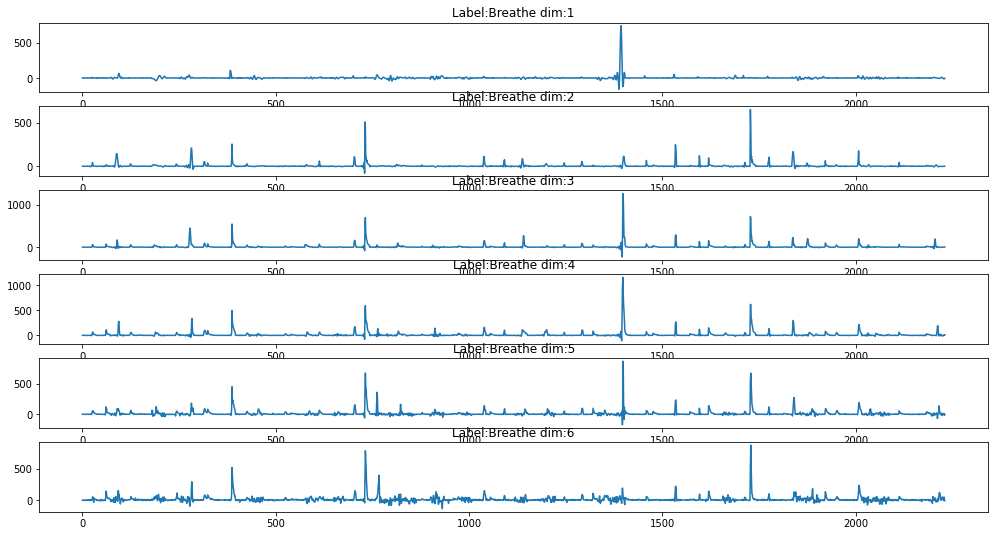

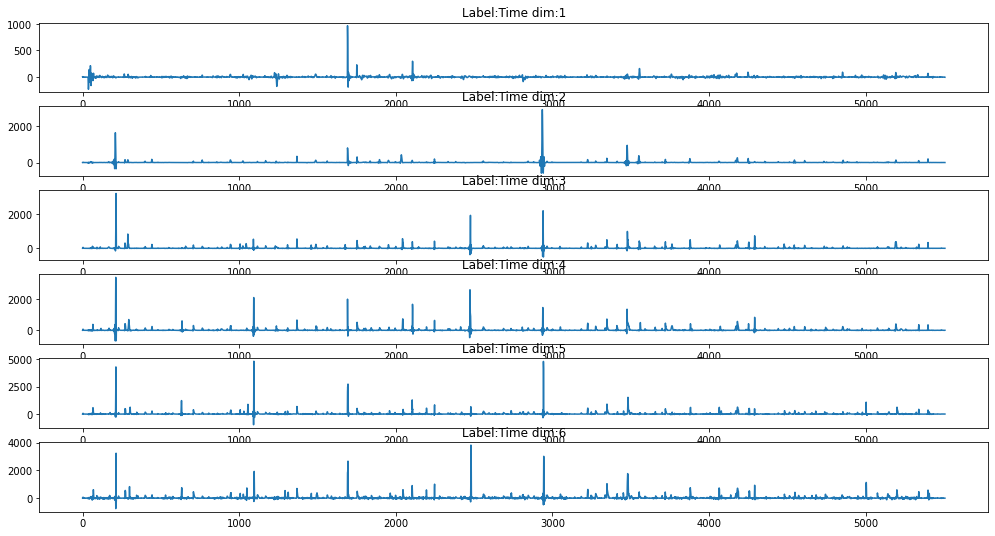

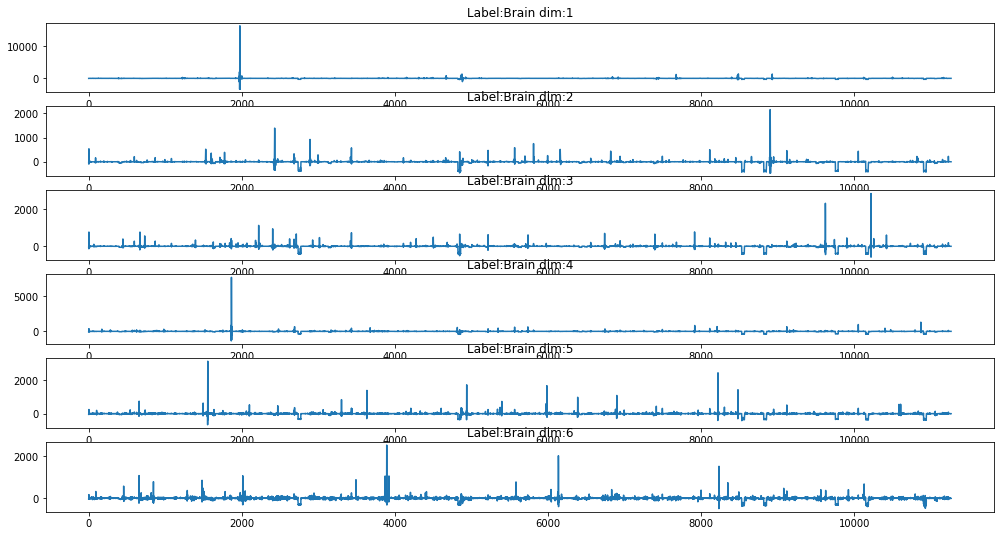

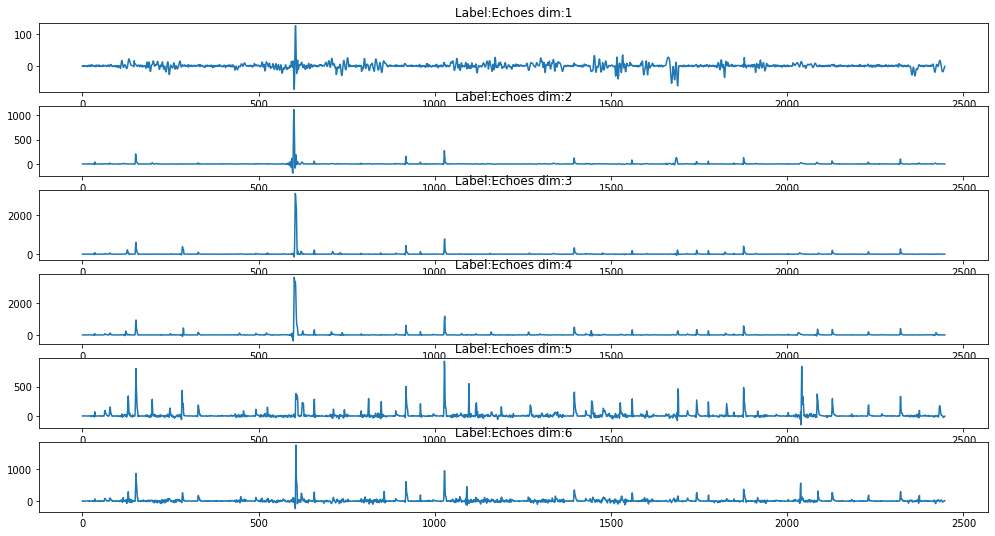

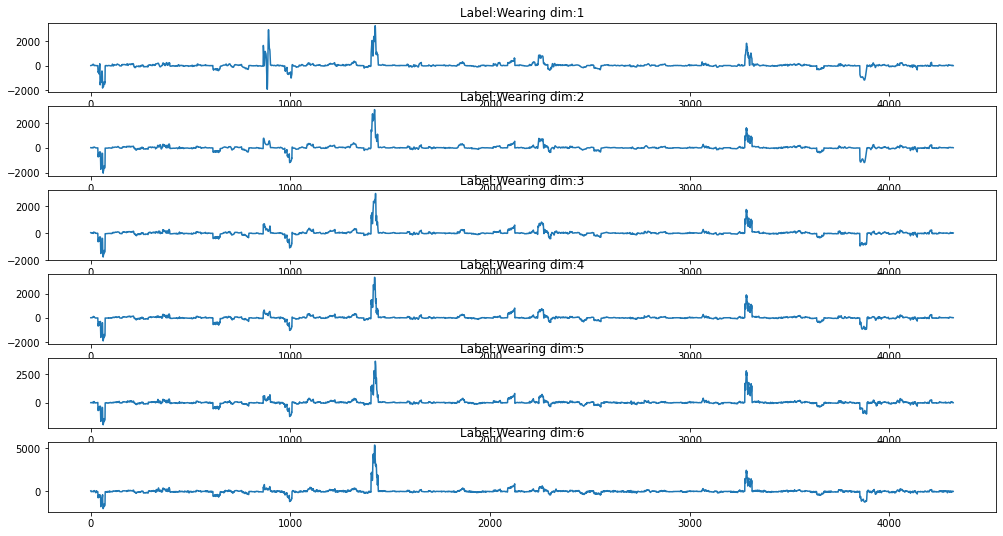

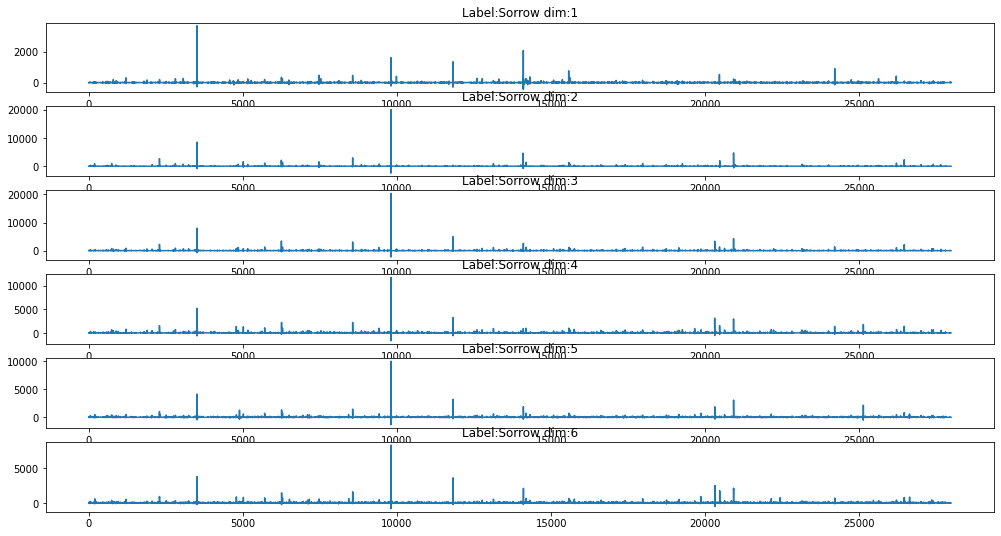

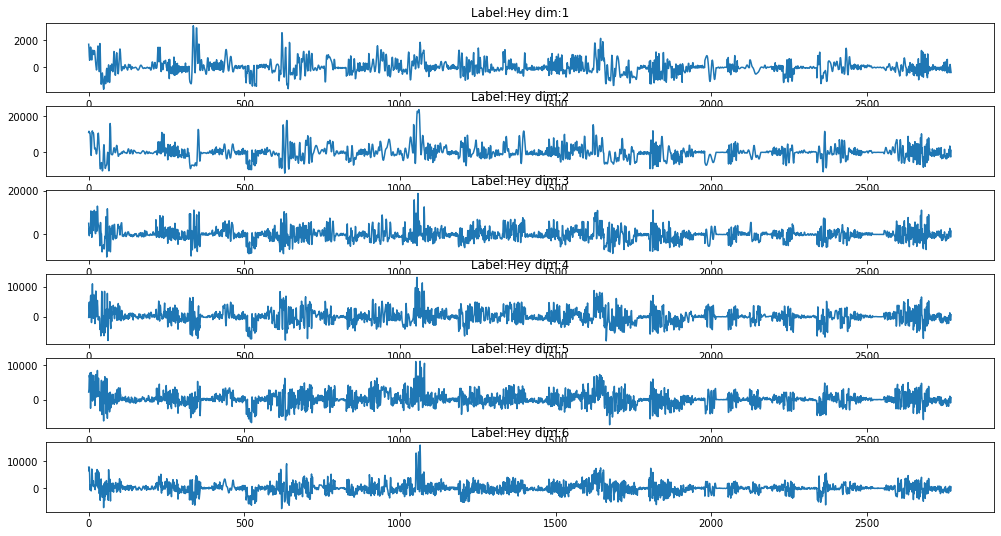

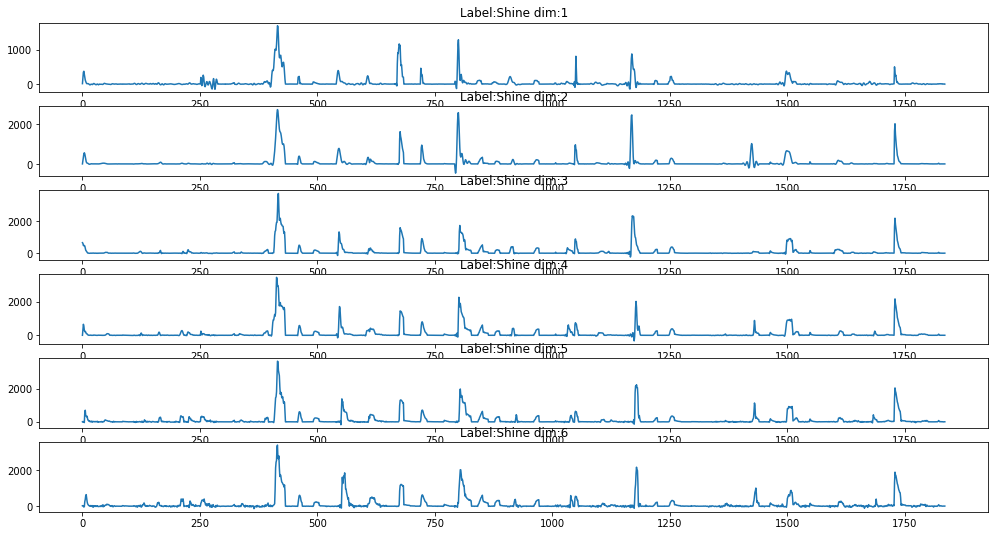

In [ ]:
num_row = x.shape[2]
num_col = 1

row = 0
for label in range(len(classes_list)):
  fig, axes = plt.subplots(num_row, num_col, figsize=(17,9))
  num = count[label]
  for i in range(x.shape[2]):
    data = np.array(x[row:num+row,:,i]).reshape(num*36)
    ax = axes[i]
    ax.set_title("Label:" +classes_list[label]+ " dim:"+str(i+1))
    ax.plot(data)
  row += num

#Split in train and test set

In [ ]:
size_train = [0,0,0,0,0,0,0,0,0,0,0,0]
size_test = [0,0,0,0,0,0,0,0,0,0,0,0]

for label in range(len(classes_list)):
  tot_label = count[label]
  size_train[label] = int(tot_label*0.8)
  size_test[label] = tot_label - size_train[label]

dim1_train = np.cumsum(size_train)[len(size_train)-1]
dim1_test = np.cumsum(size_test)[len(size_test)-1]

x_train = np.zeros((dim1_train, x.shape[1], x.shape[2]))
y_train = np.zeros((dim1_train))
x_test = np.zeros((dim1_test, x.shape[1], x.shape[2]))
y_test = np.zeros((dim1_test))

In [ ]:
row = 0
row_train = 0
row_test = 0
for label in range(len(classes_list)):
  for i in range(size_train[label]):
    #we add in train set
    batch = row + i
    #print(batch)
    x_train[row_train] = x[batch]
    y_train[row_train] = y[batch]
    row_train += 1
  row += size_train[label] 
  
  for i in range(size_test[label]):
    #we add in test set
    batch = row + i
    #print(batch)
    x_test[row_test] = x[batch]
    y_test[row_test] = y[batch]
    row_test += 1
  row += size_test[label] 
  
  
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1938, 36, 6) (1938,) (491, 36, 6) (491,)


#Data Augmentation

###SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
dim_1 = np.array(x_train).shape[0]
dim_2 = np.array(x_train).shape[1]
dim_3 = np.array(x_train).shape[2]
print(dim_1, dim_2, dim_3)

1938 36 6


In [ ]:
new_dim = dim_1 * dim_2

new_x_train = np.array(x_train).reshape(new_dim, dim_3)
print(new_x_train.shape)

(69768, 6)


In [ ]:
new_y_train = []
for i in range(len(y_train)):
    # print(y_train[i])
    new_y_train.extend([y_train[i]]*dim_2)

new_y_train = np.array(new_y_train)

print(new_y_train, new_y_train.shape)

[ 0.  0.  0. ... 11. 11. 11.] (69768,)


In [ ]:
# transform the dataset
oversample = SMOTE()
X_Train, Y_Train = oversample.fit_resample(new_x_train, new_y_train)
# summarize the new class distribution
counter = Counter(Y_Train)
print('The number of samples in TRAIN: ', counter)

The number of samples in TRAIN:  Counter({0.0: 22356, 1.0: 22356, 2.0: 22356, 3.0: 22356, 4.0: 22356, 5.0: 22356, 6.0: 22356, 7.0: 22356, 8.0: 22356, 9.0: 22356, 10.0: 22356, 11.0: 22356})


In [ ]:
x_train_SMOTE = X_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2, dim_3)
print(x_train_SMOTE.shape)

(7452, 36, 6)


In [ ]:
y_train_SMOTE = []
for i in range(int(X_Train.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_train_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
    

In [ ]:
counter = Counter(y_train_SMOTE)
print('The number of samples in TRAIN: ', counter)

The number of samples in TRAIN:  Counter({0.0: 621, 1.0: 621, 2.0: 621, 3.0: 621, 4.0: 621, 5.0: 621, 6.0: 621, 7.0: 621, 8.0: 621, 9.0: 621, 10.0: 621, 11.0: 621})


In [ ]:
y_train_SMOTE = np.array(y_train_SMOTE)
print(y_train_SMOTE, y_train_SMOTE.shape)

[ 0.  0.  0. ... 11. 11. 11.] (7452,)


In [ ]:
counter = Counter(y_train_SMOTE)
tot_number = 0;

for i in range(len(classes_list)):
  count[i] = counter[i]
  tot_number += count[i]
  print("The number of ", classes_list[i], " is: ", count[i])

print("The total number of data is: ", tot_number)

The number of  Wish  is:  621
The number of  Another  is:  621
The number of  Comfortably  is:  621
The number of  Money  is:  621
The number of  Breathe  is:  621
The number of  Time  is:  621
The number of  Brain  is:  621
The number of  Echoes  is:  621
The number of  Wearing  is:  621
The number of  Sorrow  is:  621
The number of  Hey  is:  621
The number of  Shine  is:  621
The total number of data is:  7452


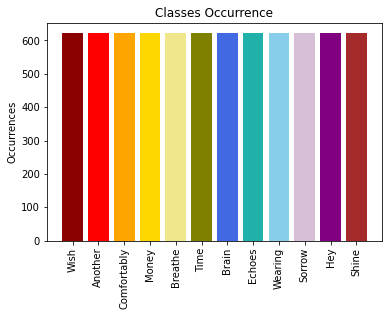

In [ ]:
erc = ['darkred','red', 'orange', 'gold', 'khaki', 'olive', 'royalblue', 'lightseagreen', 'skyblue','thistle', 'purple', 'brown']
plt.bar(classes_list, count, color = erc)
plt.title("Classes Occurrence")
plt.ylabel("Occurrences")
plt.xticks(rotation=90)
plt.yticks
plt.show()

# Utils functions

In [ ]:
def plot_confusionMatrix(y_test, predictions, label_mapping):
  # Compute the confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

  # Compute the classification metrics
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()


In [ ]:
# Map labels to integers
label_mapping = {
          'Wish': 0,         # 0
          'Another': 1,      # 1
          'Comfortably': 2,  # 2
          'Money': 3,        # 3
          'Breathe': 4,      # 4
          'Time': 5,         # 5
          'Brain': 6,        # 6
          'Echoes': 7,       # 7
          'Wearing': 8,      # 8
          'Sorrow': 9,       # 9
          'Hey': 10,         # 10
          'Shine': 11        # 11
}

##Size and metadata

In [ ]:
x_train_SMOTE.shape, y_train_SMOTE.shape, x_test.shape, y_test.shape

((7452, 36, 6), (7452,), (491, 36, 6), (491,))

In [ ]:
# Convert the sparse labels to categorical values
y_train_SMOTE = tfk.utils.to_categorical(y_train_SMOTE)
y_test = tfk.utils.to_categorical(y_test)
x_train_SMOTE.shape, y_train_SMOTE.shape, x_test.shape, y_test.shape

((7452, 36, 6), (7452, 12), (491, 36, 6), (491, 12))

In [ ]:
input_shape = x_train_SMOTE.shape[1:]
classes = y_train_SMOTE.shape[-1]
batch_size = 32
epochs = 200

#1D ResNet

In [ ]:
def build_resNet(input_shape, nb_classes):
    n_feature_maps = 64

    input_layer = tf.keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = tf.keras.layers.BatchNormalization()(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)

    conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = tf.keras.layers.BatchNormalization()(conv_y)
    conv_y = tf.keras.layers.Activation('relu')(conv_y)

    conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = tf.keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tf.keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = tf.keras.layers.add([shortcut_y, conv_z])
    output_block_1 = tf.keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = tf.keras.layers.BatchNormalization()(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)

    conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tf.keras.layers.BatchNormalization()(conv_y)
    conv_y = tf.keras.layers.Activation('relu')(conv_y)

    conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tf.keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = tf.keras.layers.add([shortcut_y, conv_z])
    output_block_2 = tf.keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = tf.keras.layers.BatchNormalization()(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)

    conv_y = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tf.keras.layers.BatchNormalization()(conv_y)
    conv_y = tf.keras.layers.Activation('relu')(conv_y)

    conv_z = tf.keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tf.keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = tf.keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = tf.keras.layers.add([shortcut_y, conv_z])
    output_block_3 = tf.keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = tf.keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    return model

In [ ]:
resNet = build_resNet(input_shape, classes)
resNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 64)       3136        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 36, 64)       0           ['batch_normalization[0][0]']

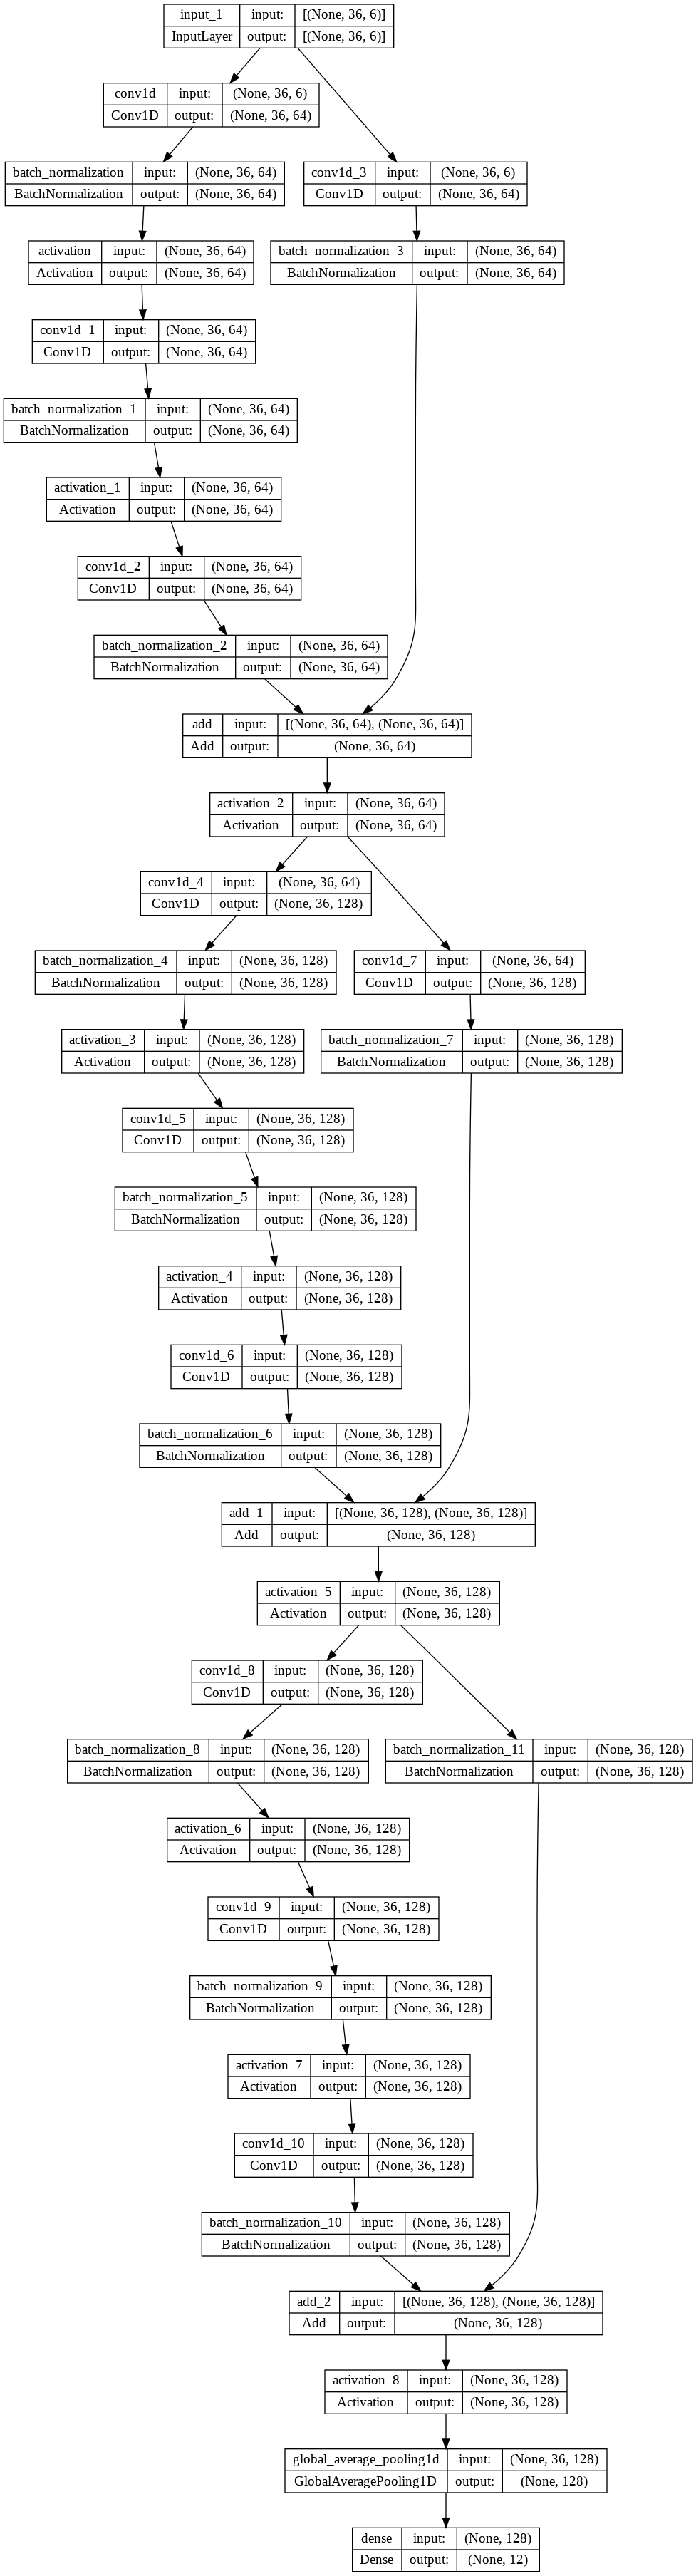

In [ ]:
plot_model(resNet, show_shapes=True, show_layer_names=True)

In [ ]:
valid_set = (x_test, y_test)
# Train the model
history = resNet.fit(
    x = x_train_SMOTE,
    y = y_train_SMOTE,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_set,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
233/233 [==============================] - 30s 113ms/step - loss: 1.1551 - accuracy: 0.5852 - val_loss: 1.7883 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 2/200
233/233 [==============================] - 28s 121ms/step - loss: 0.8297 - accuracy: 0.7008 - val_loss: 2.6665 - val_accuracy: 0.3788 - lr: 0.0010
Epoch 3/200
233/233 [==============================] - 29s 125ms/step - loss: 0.7543 - accuracy: 0.7315 - val_loss: 1.9821 - val_accuracy: 0.4807 - lr: 0.0010
Epoch 4/200
233/233 [==============================] - 26s 112ms/step - loss: 0.6761 - accuracy: 0.7619 - val_loss: 2.2428 - val_accuracy: 0.3442 - lr: 0.0010
Epoch 5/200
233/233 [==============================] - 29s 123ms/step - loss: 0.6437 - accuracy: 0.7739 - val_loss: 2.1916 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 6/200
233/233 [==============================] - 26s 113ms/step - loss: 0.6095 - accuracy: 0.7826 - val_loss: 2.9346 - val_accuracy: 0.2464 - lr: 0.0010
Epoch 7/200
233/233 [=========================

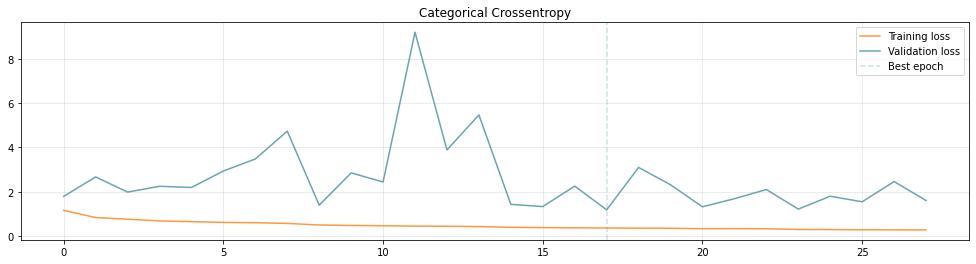

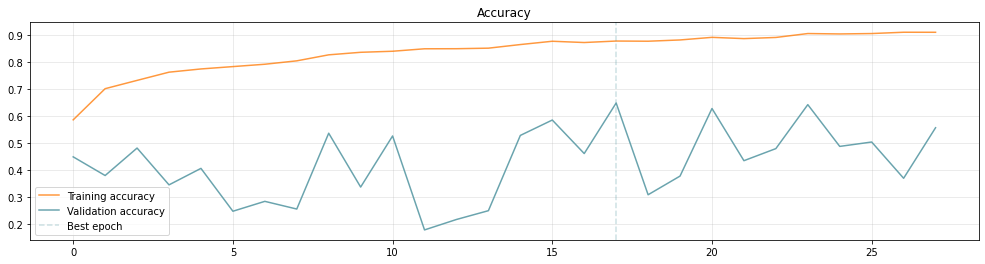

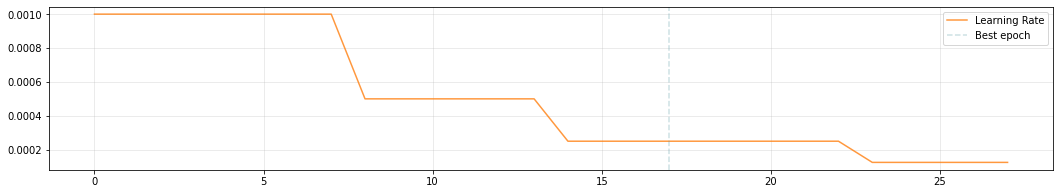

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set with the LSTM
predictions = resNet.predict(x_test)
predictions.shape

16/16 [==============================] - 1s 27ms/step


(491, 12)

Accuracy: 0.6477
Precision: 0.5978
Recall: 0.5417
F1: 0.5412


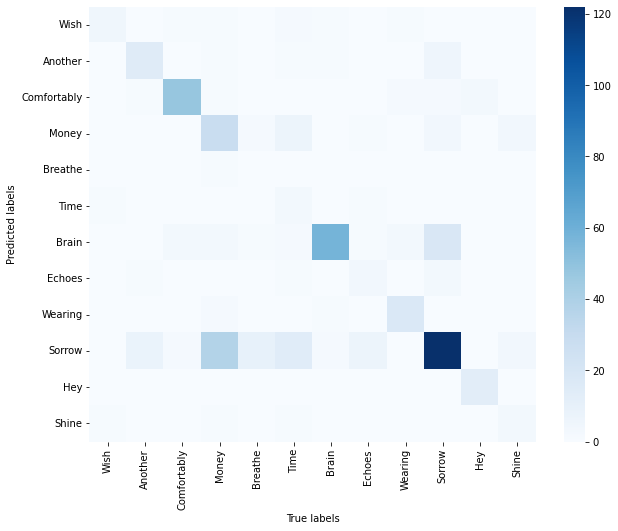

In [ ]:
plot_confusionMatrix(y_test, predictions, label_mapping)

In [ ]:
resNet.save('resNet_1.h5')